Library Imports

In [ ]:
import json
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import PoissonRegressor, Ridge, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score, max_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor

from scipy import stats
from scipy.stats import poisson

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def process_delivery(delivery, ball_count, team_name, opposition_team):
  runs = delivery['runs']['total']
  wicket = 1 if 'wicket' in delivery else 0
  batter = delivery['batter']
  bowler = delivery['bowler']
  non_striker = delivery['non_striker']
  return ball_count, runs, wicket, team_name, opposition_team, batter, bowler, non_striker

Data Extraction and Preprocessing

In [ ]:
††json_base_dir = 'drive/My Drive/Durham/Dissertation/JSON'
csv_base_dir = 'drive/My Drive/Durham/Dissertation/JSON_cl'

os.makedirs(csv_base_dir, exist_ok=True)

start_file = 1252666
end_file = 1355639

for file_num in range(start_file, end_file + 1):
    try:
        ball_numbers = []
        runs_scored = []
        wickets_taken = []
        team_names = []
        innings_list = []
        venues = []
        toss_winners = []
        toss_decisions = []
        opposition_teams = []
        batters = []
        bowlers = []
        non_strikers = []

        current_innings = 1
        last_team = None

        json_file_path = os.path.join(json_base_dir, f"{file_num}.json")

        with open(json_file_path, 'r') as file:
            data = json.load(file)
            innings_data = data['innings']
            year = data['info']['season']
            gender = data['info']['gender']
            winner = data['info']['outcome'].get('winner', 'Tie')
            winning_margin = None
            if 'by' in data['info']['outcome']:
                if 'runs' in data['info']['outcome']['by']:
                    winning_margin = str(data['info']['outcome']['by']['runs']) + ' runs'
                elif 'wickets' in data['info']['outcome']['by']:
                    winning_margin = str(data['info']['outcome']['by']['wickets']) + ' wickets'

            venue = data['info']['venue']
            toss_winner = data['info']['toss']['winner']
            toss_decision = data['info']['toss']['decision']

        ball_count = 0
        for innings in innings_data:
            team_name = innings['team']
            opposition_team = next((inn['team'] for inn in innings_data if inn['team'] != team_name), None)

            for over in innings['overs']:
                for delivery in over['deliveries']:
                    ball_count += 1
                    if last_team and team_name != last_team:

                    runs_scored.append(runs)
                    wickets_taken.append(wicket)
                    team_names.append(team)
                    innings_list.append(current_innings)
                    venues.append(venue)
                    toss_winners.append(toss_winner)
                    toss_decisions.append(toss_decision)
                    opposition_teams.append(opp_team)
                    batters.append(batter)
                    bowlers.append(bowler)
                    non_strikers.append(non_striker)
                    last_team = team_name

        df = pd.DataFrame({
            'Ball': ball_numbers,
            'Runs': runs_scored,
            'Wicket': wickets_taken,
            'Team': team_names,
            'Innings': innings_list,
            'Year': year,
            'Gender': gender,
            'Winner': winner,
            'Winning_Margin': winning_margin,
            'Venue': venues,
            'Toss_Winner': toss_winners,
            'Toss_Decision': toss_decisions,
            'Opposition_Team': opposition_teams,
            'Batter': batters,
            'Bowler': bowlers,
            'Non_Striker': non_strikers
        })

        df['Cumulative_Runs'] = df.groupby('Innings')['Runs'].cumsum()
        df['Cumulative_Wickets'] = df.groupby('Innings')['Wicket'].cumsum()

        csv_file_name = f"{file_num}_cl.csv"
        csv_file_path = os.path.join(csv_base_dir, csv_file_name)

        df.to_csv(csv_file_path, index=False)
        print(f"CSV file saved as: {csv_file_path}")

    except FileNotFoundError:
        print(f"No JSON {file_num}")
        continue
    except Exception as e:
        print(f"An error occurred {file_num}: {e}")
        continue


Выходные данные были обрезаны до нескольких последних строк (5000).
No JSON file found for 1350640, skipping.
No JSON file found for 1350641, skipping.
No JSON file found for 1350642, skipping.
No JSON file found for 1350643, skipping.
No JSON file found for 1350644, skipping.
No JSON file found for 1350645, skipping.
No JSON file found for 1350646, skipping.
No JSON file found for 1350647, skipping.
No JSON file found for 1350648, skipping.
No JSON file found for 1350649, skipping.
No JSON file found for 1350650, skipping.
No JSON file found for 1350651, skipping.
No JSON file found for 1350652, skipping.
No JSON file found for 1350653, skipping.
No JSON file found for 1350654, skipping.
No JSON file found for 1350655, skipping.
No JSON file found for 1350656, skipping.
No JSON file found for 1350657, skipping.
No JSON file found for 1350658, skipping.
No JSON file found for 1350659, skipping.
No JSON file found for 1350660, skipping.
No JSON file found for 1350661, skipping.
No JSON 

Feature Engineering and Statistical Analysis

In [ ]:
csv_file_path = 'drive/My Drive/Durham/Dissertation/CSV/combined_csv_file.csv'

df = pd.read_csv(csv_file_path)

team_performance = {}
team_win_streak = {}
team_loss_streak = {}
team_wins = {}
team_matches = {}
head_to_head_wins = {}
venue_wins = {}
venue_matches = {}
opposition_team_performance = {}
player_batting_stats = {}
player_bowling_stats = {}
team_innings_runs = {}
team_innings_wickets = {}
team_innings_count = {}

window_size = 5

for index, row in df.iterrows():
    team = row['Team']
    opposition_team = row['Opposition_Team']
    year = row['Year']
    gender = row['Gender']
    winner = row['Winner']
    venue = row['Venue']
    runs = row['Runs']
    wicket = row['Wicket']
    batter = row['Batter']
    bowler = row['Bowler']
    innings = row['Innings']

    if team not in team_performance:
        team_performance[team] = []
    team_performance[team].append(runs)

    if opposition_team not in opposition_team_performance:
        opposition_team_performance[opposition_team] = []
    opposition_team_performance[opposition_team].append(runs)

    team_gender_key = (team, gender)
    if team_gender_key not in team_win_streak:
        team_win_streak[team_gender_key] = 0
        team_loss_streak[team_gender_key] = 0
        team_wins[team_gender_key] = 0
        team_matches[team_gender_key] = 0
    team_matches[team_gender_key] += 1
    if team == winner:
        team_win_streak[team_gender_key] += 1
        team_loss_streak[team_gender_key] = 0
        team_wins[team_gender_key] += 1
    else:
        team_win_streak[team_gender_key] = 0
        team_loss_streak[team_gender_key] += 1

    team_opponent_key = (team, opposition_team, gender)
    if team_opponent_key not in head_to_head_wins:
        head_to_head_wins[team_opponent_key] = 0
    if team == winner:
        head_to_head_wins[team_opponent_key] += 1

    venue_key = (venue, team)
    if venue_key not in venue_wins:
        venue_wins[venue_key] = 0
        venue_matches[venue_key] = 0
    venue_matches[venue_key] += 1
    if team == winner:
        venue_wins[venue_key] += 1

    if batter not in player_batting_stats:
        player_batting_stats[batter] = {'runs': 0, 'balls': 0, 'outs': 0}
    player_batting_stats[batter]['runs'] += runs
    player_batting_stats[batter]['balls'] += 1
    if wicket:
        player_batting_stats[batter]['outs'] += 1

    if bowler not in player_bowling_stats:
        player_bowling_stats[bowler] = {'wickets': 0, 'runs_conceded': 0, 'balls_bowled': 0}
    player_bowling_stats[bowler]['runs_conceded'] += runs
    player_bowling_stats[bowler]['balls_bowled'] += 1
    if wicket:
        player_bowling_stats[bowler]['wickets'] += 1

    if team not in team_innings_runs:
        team_innings_runs[team] = []
        team_innings_wickets[team] = []
        team_innings_count[team] = 0
    team_innings_runs[team].append(runs)
    team_innings_wickets[team].append(wicket)
    team_innings_count[team] += 1

df['Team_Moving_Average'] = df.groupby('Team')['Runs'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
df['Opposition_Team_Moving_Average'] = df.groupby('Opposition_Team')['Runs'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

df['Win_Streak'] = df.apply(lambda row: team_win_streak.get((row['Team'], row['Gender']), 0), axis=1)
df['Loss_Streak'] = df.apply(lambda row: team_loss_streak.get((row['Team'], row['Gender']), 0), axis=1)
df['Win_Rate'] = df.apply(lambda row: team_wins.get((row['Team'], row['Gender']), 0) / team_matches.get((row['Team'], row['Gender']), 1), axis=1)
df['H2H_Wins'] = df.apply(lambda row: head_to_head_wins.get((row['Team'], row['Opposition_Team'], row['Gender']), 0), axis=1)
df['Venue_Win_Percentage'] = df.apply(lambda row: venue_wins.get((row['Venue'], row['Team']), 0) / venue_matches.get((row['Venue'], row['Team']), 1), axis=1)

df['Batter_Runs'] = df['Batter'].map(lambda x: player_batting_stats[x]['runs'] if x in player_batting_stats else 0)
df['Batter_Balls'] = df['Batter'].map(lambda x: player_batting_stats[x]['balls'] if x in player_batting_stats else 0)
df['Batter_Average'] = df['Batter'].map(lambda x: player_batting_stats[x]['runs'] / player_batting_stats[x]['outs'] if x in player_batting_stats and player_batting_stats[x]['outs'] > 0 else 0)
df['Batter_Strike_Rate'] = df['Batter'].map(lambda x: (player_batting_stats[x]['runs'] / player_batting_stats[x]['balls']) * 100 if x in player_batting_stats and player_batting_stats[x]['balls'] > 0 else 0)

df['Bowler_Wickets'] = df['Bowler'].map(lambda x: player_bowling_stats[x]['wickets'] if x in player_bowling_stats else 0)
df['Bowler_Runs_Conceded'] = df['Bowler'].map(lambda x: player_bowling_stats[x]['runs_conceded'] if x in player_bowling_stats else 0)
df['Bowler_Balls'] = df['Bowler'].map(lambda x: player_bowling_stats[x]['balls_bowled'] if x in player_bowling_stats else 0)
df['Bowler_Average'] = df['Bowler'].map(lambda x: player_bowling_stats[x]['runs_conceded'] / player_bowling_stats[x]['wickets'] if x in player_bowling_stats and player_bowling_stats[x]['wickets'] > 0 else 0)
df['Bowler_Economy'] = df['Bowler'].map(lambda x: (player_bowling_stats[x]['runs_conceded'] / player_bowling_stats[x]['balls_bowled']) * 6 if x in player_bowling_stats and player_bowling_stats[x]['balls_bowled'] > 0 else 0)

def calculate_team_averages(row):
    team = row['Team']
    ball = row['Ball']

    if team in team_innings_runs and team_innings_count[team] > 0:
        avg_runs = sum(team_innings_runs[team]) / team_innings_count[team]
        avg_wickets = sum(team_innings_wickets[team]) / team_innings_count[team]

        innings_progress = (ball - 1) / 100
        avg_runs_per_ball = avg_runs * innings_progress
        avg_wickets_per_ball = avg_wickets * innings_progress

        return pd.Series({
            'Team_Avg_Runs_Per_Innings': avg_runs,
            'Team_Avg_Wickets_Per_Innings': avg_wickets,
            'Team_Avg_Runs_Per_Ball': avg_runs_per_ball,
            'Team_Avg_Wickets_Per_Ball': avg_wickets_per_ball
        })
    else:
        return pd.Series({
            'Team_Avg_Runs_Per_Innings': 0,
            'Team_Avg_Wickets_Per_Innings': 0,
            'Team_Avg_Runs_Per_Ball': 0,
            'Team_Avg_Wickets_Per_Ball': 0
        })

df = df.join(df.apply(calculate_team_averages, axis=1))

output_csv_path = 'drive/My Drive/Durham/Dissertation/CSV/updated_combined_csv_file.csv'
df.to_csv(output_csv_path, index=False)
print(f"Updated CSV file saved as: {output_csv_path}")

print(f"Total wickets in all matches: {df['Wicket'].sum()}")
print(f"Wicket distribution:\n{df['Wicket'].value_counts(normalize=True)}")

Updated CSV file saved as: drive/My Drive/Durham/Dissertation/CSV/updated_combined_csv_file.csv
Total wickets in all matches: 2178
Wicket distribution:
Wicket
0    0.940204
1    0.059796
Name: proportion, dtype: float64


Loading CSV file

In [ ]:
file_path = 'drive/My Drive/Durham/Dissertation/CSV/combined_data11 (2).csv'
df = pd.read_csv(file_path)

initial_inspection = df.head()
missing_values = df.isnull().sum()

initial_inspection, missing_values

(   Ball  Runs  Overs  Wicket              Team  Innings  Match  Year Gender  \
 0     1     0    0.1       0  Oval Invincibles        1      1  2021   male   
 1     2     1    0.2       0  Oval Invincibles        1      1  2021   male   
 2     3     0    0.3       0  Oval Invincibles        1      1  2021   male   
 3     4     6    0.4       0  Oval Invincibles        1      1  2021   male   
 4     5     0    1.0       1  Oval Invincibles        1      1  2021   male   
 
              Winner  ... H2H_Wins Venue_Win_Percentage Batter_Runs  \
 0  Oval Invincibles  ...        1                  1.0          20   
 1  Oval Invincibles  ...        1                  1.0          20   
 2  Oval Invincibles  ...        1                  1.0           6   
 3  Oval Invincibles  ...        1                  1.0           6   
 4  Oval Invincibles  ...        1                  1.0           6   
 
   Batter_Balls Batter_Strike_Rate  Bowler_Wickets  Bowler_Runs_Conceded  \
 0           1

Statistical summary

In [ ]:
statistical_summary = df.describe(include='all')

statistical_summary

,Ball,Runs,Wicket,Team,Innings,Match,Year,Gender,Winner,Winning_Margin,...,Loss_Streak,Win_Rate,H2H_Wins,Venue_Win_Percentage,Batter_Runs,Batter_Balls,Batter_Strike_Rate,Bowler_Wickets,Bowler_Runs_Conceded,Bowler_Balls
count,36099.000000,36099.000000,36099.000000,36099,36099.000000,36099.000000,36099.000000,36099,36099,36099,...,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.0,36099.000000,36099.000000
unique,NaN,NaN,NaN,8,NaN,NaN,NaN,2,9,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Southern Brave,NaN,NaN,NaN,male,Southern Brave,6 wickets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,4872,NaN,NaN,NaN,18834,6836,3692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,50.597053,1.345384,0.059835,NaN,1.482423,2.254218,2021.980193,NaN,NaN,NaN,...,0.933793,0.495465,1.111194,0.493476,182.092136,131.882850,135.634917,0.0,166.993933,129.731765
std,29.341250,1.572308,0.237185,NaN,0.499698,1.112489,0.816963,NaN,NaN,NaN,...,1.294856,0.306352,0.955368,0.336191,152.316366,106.984258,28.413871,0.0,126.069324,98.825560
min,1.000000,0.000000,0.000000,NaN,1.000000,1.000000,2021.000000,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,2.000000,5.000000
25%,25.000000,0.000000,0.000000,NaN,1.000000,1.000000,2021.000000,NaN,NaN,NaN,...,0.000000,0.333333,0.000000,0.277778,63.000000,47.000000,118.840580,0.0,64.000000,50.000000
50%,50.000000,1.000000,0.000000,NaN,1.000000,2.000000,2022.000000,NaN,NaN,NaN,...,1.000000,0.500000,1.000000,0.500000,138.000000,102.000000,135.714286,0.0,135.000000,104.000000
75%,75.000000,2.000000,0.000000,NaN,2.000000,3.000000,2023.000000,NaN,NaN,NaN,...,1.000000,0.714286,2.000000,0.733333,263.000000,193.000000,151.250000,0.0,246.000000,190.000000


In [ ]:
df[df['Innings'] == 1]

,Ball,Runs,Wicket,Team,Innings,Match,Year,Gender,Winner,Winning_Margin,...,Loss_Streak,Win_Rate,H2H_Wins,Venue_Win_Percentage,Batter_Runs,Batter_Balls,Batter_Strike_Rate,Bowler_Wickets,Bowler_Runs_Conceded,Bowler_Balls
0,1,0,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,9 runs,...,0,1.000000,1,1.0,20,12,166.666667,0,25,20
1,2,1,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,9 runs,...,0,1.000000,1,1.0,20,12,166.666667,0,25,20
2,3,0,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,9 runs,...,0,1.000000,1,1.0,6,3,200.000000,0,25,20
3,4,6,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,9 runs,...,0,1.000000,1,1.0,6,3,200.000000,0,25,20
4,5,0,1,Oval Invincibles,1,1,2021,male,Oval Invincibles,9 runs,...,0,1.000000,1,1.0,6,3,200.000000,0,25,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35987,100,1,0,Oval Invincibles,1,4,2023,male,Oval Invincibles,14 runs,...,0,0.777778,3,1.0,397,219,181.278539,0,149,93
35988,101,1,0,Oval Invincibles,1,4,2023,male,Oval Invincibles,14 runs,...,0,0.777778,3,1.0,113,73,154.794521,0,149,93
35989,102,1,0,Oval Invincibles,1,4,2023,male,Oval Invincibles,14 runs,...,0,0.777778,3,1.0,397,219,181.278539,0,149,93
35990,103,1,0,Oval Invincibles,1,4,2023,male,Oval Invincibles,14 runs,...,0,0.777778,3,1.0,113,73,154.794521,0,149,93


Team Wicket Analysis

In [ ]:
def process_innings(innings_df):
    return innings_df['Cumulative_Wickets'].max()

team_stats = {}
for (match, innings, team), innings_df in df.groupby(['Match', 'Innings', 'Team']):
    wickets = process_innings(innings_df)
    if team not in team_stats:
        team_stats[team] = []
    team_stats[team].append(wickets)

team_averages = {team: np.mean(stats) for team, stats in team_stats.items()}

team_models = {team: poisson(avg) for team, avg in team_averages.items()}

print("Average wickets per innings for each team:")
for team, avg in team_averages.items():
    print(f"{team}: {avg:.2f}")

def wicket_probability(team, x_wickets):
    if team not in team_models:
        return None
    return team_models[team].pmf(x_wickets)

print("\nProbabilities for 0 to 10 wickets in an innings:")
for team in team_averages.keys():
    print(f"\n{team}:")
    for wickets in range(11):
        prob = wicket_probability(team, wickets)
        print(f"  {wickets} wickets: {prob:.4f}")

balls_per_wicket = {team: 100 / avg for team, avg in team_averages.items()}

print("\nAverage number of balls before a wicket falls:")
for team, balls in balls_per_wicket.items():
    print(f"{team}: {balls:.2f}")


Average wickets per innings for each team:
Birmingham Phoenix: 8.67
London Spirit: 8.00
Manchester Originals: 8.11
Northern Superchargers: 8.22
Oval Invincibles: 8.22
Southern Brave: 7.45
Trent Rockets: 8.56
Welsh Fire: 8.30

Probabilities for 0 to 10 wickets in an innings:

Birmingham Phoenix:
  0 wickets: 0.0002
  1 wickets: 0.0015
  2 wickets: 0.0065
  3 wickets: 0.0187
  4 wickets: 0.0405
  5 wickets: 0.0702
  6 wickets: 0.1014
  7 wickets: 0.1255
  8 wickets: 0.1360
  9 wickets: 0.1309
  10 wickets: 0.1135

London Spirit:
  0 wickets: 0.0003
  1 wickets: 0.0027
  2 wickets: 0.0107
  3 wickets: 0.0286
  4 wickets: 0.0573
  5 wickets: 0.0916
  6 wickets: 0.1221
  7 wickets: 0.1396
  8 wickets: 0.1396
  9 wickets: 0.1241
  10 wickets: 0.0993

Manchester Originals:
  0 wickets: 0.0003
  1 wickets: 0.0024
  2 wickets: 0.0099
  3 wickets: 0.0267
  4 wickets: 0.0541
  5 wickets: 0.0878
  6 wickets: 0.1187
  7 wickets: 0.1376
  8 wickets: 0.1395
  9 wickets: 0.1257
  10 wickets: 0.1020

N

Run Rate Analysis

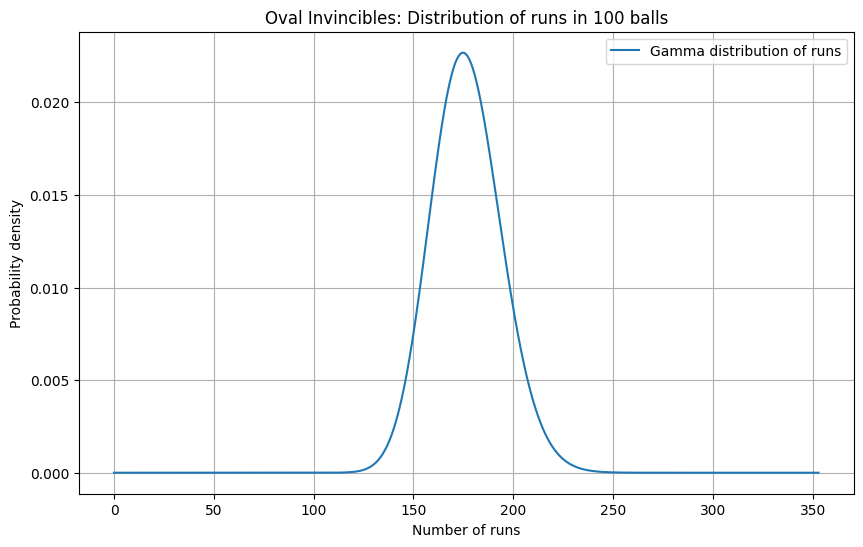

Expected number of runs in 100 balls: 176.64
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 0.9998
Probability of scoring more than 140 runs: 0.9862
Probability of scoring more than 160 runs: 0.8263


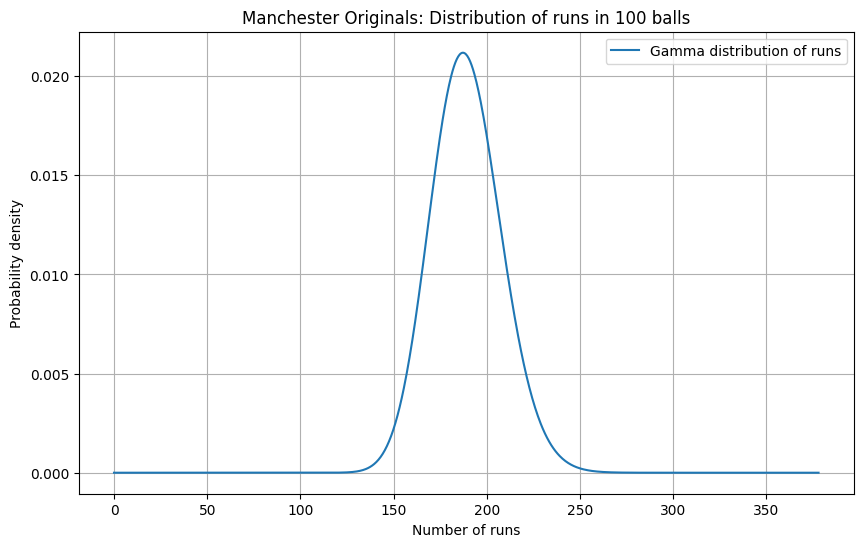

Expected number of runs in 100 balls: 189.09
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 1.0000
Probability of scoring more than 140 runs: 0.9977
Probability of scoring more than 160 runs: 0.9443


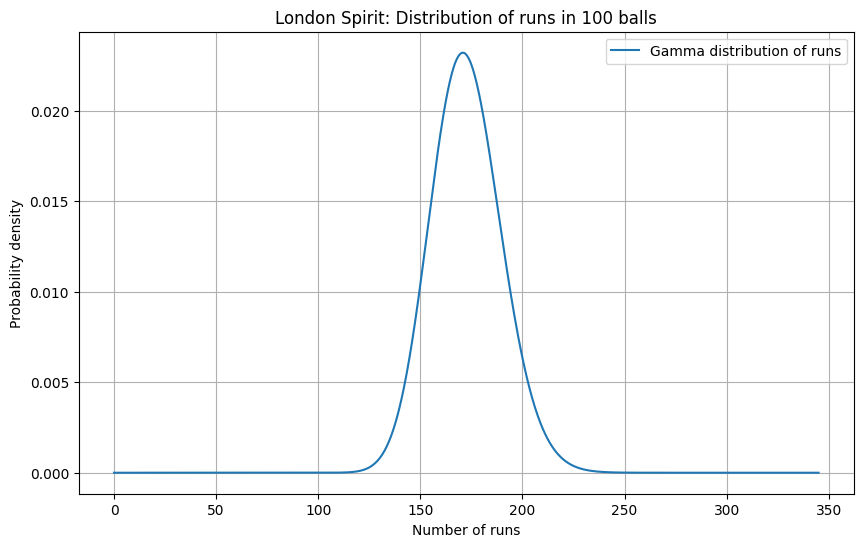

Expected number of runs in 100 balls: 172.57
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 0.9997
Probability of scoring more than 140 runs: 0.9765
Probability of scoring more than 160 runs: 0.7621


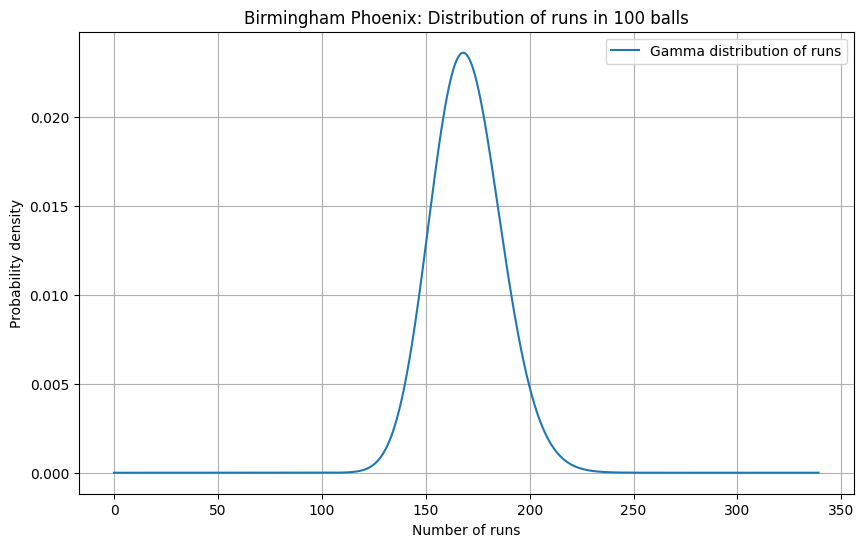

Expected number of runs in 100 balls: 169.72
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 0.9994
Probability of scoring more than 140 runs: 0.9665
Probability of scoring more than 160 runs: 0.7091


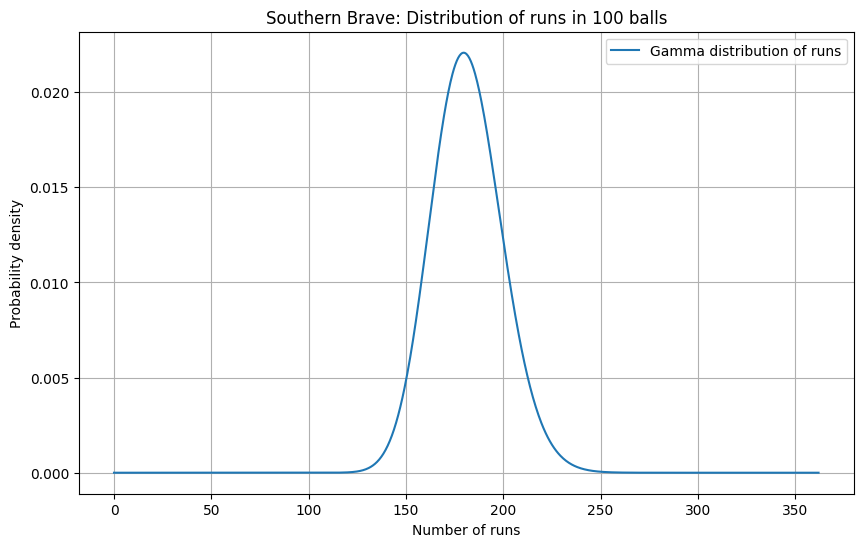

Expected number of runs in 100 balls: 181.48
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 0.9999
Probability of scoring more than 140 runs: 0.9929
Probability of scoring more than 160 runs: 0.8850


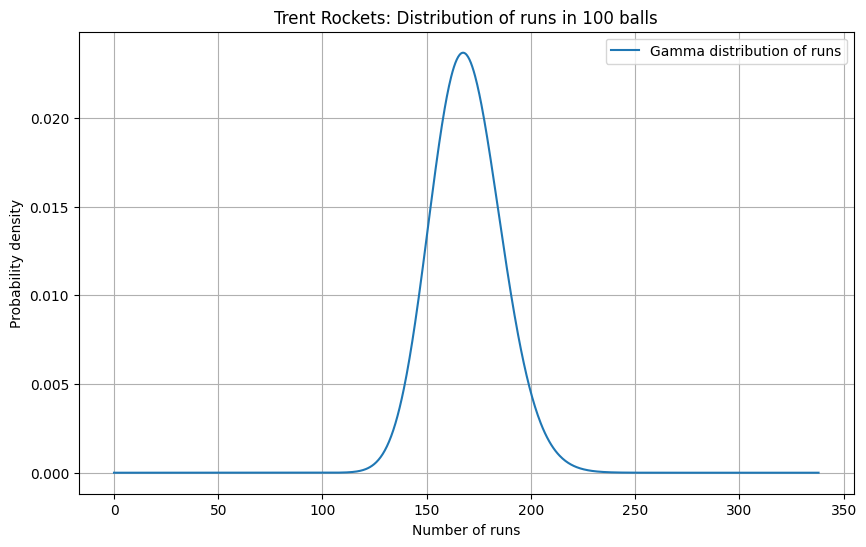

Expected number of runs in 100 balls: 169.16
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 0.9993
Probability of scoring more than 140 runs: 0.9641
Probability of scoring more than 160 runs: 0.6978


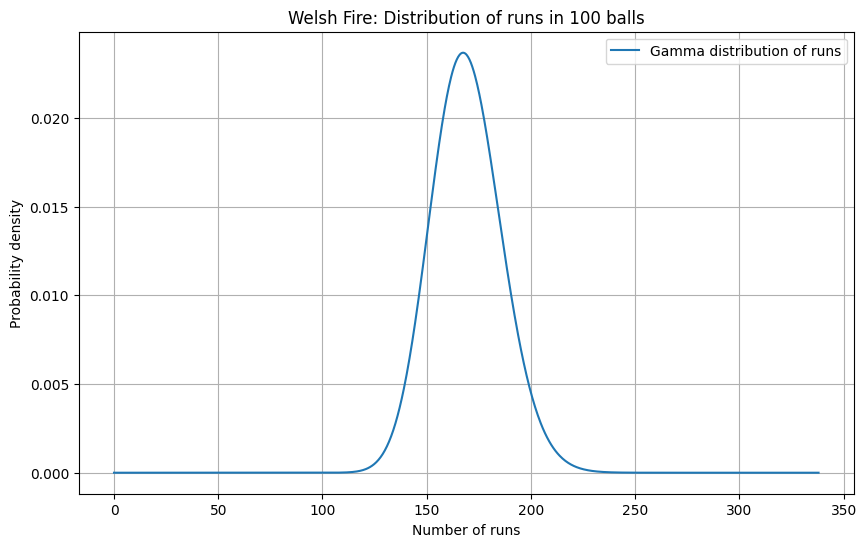

Expected number of runs in 100 balls: 169.16
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 0.9993
Probability of scoring more than 140 runs: 0.9641
Probability of scoring more than 160 runs: 0.6978


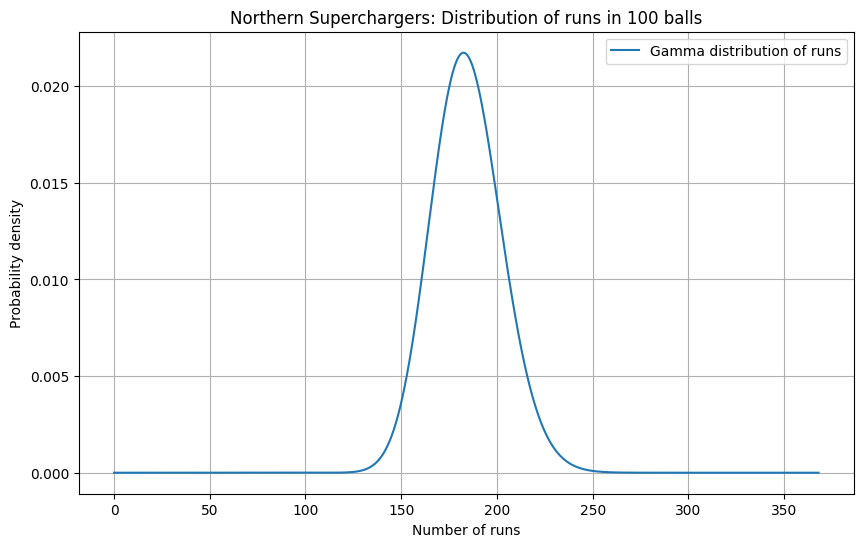

Expected number of runs in 100 balls: 184.40
Probability of scoring more than 100 runs: 1.0000
Probability of scoring more than 120 runs: 1.0000
Probability of scoring more than 140 runs: 0.9953
Probability of scoring more than 160 runs: 0.9120


In [ ]:
def calculate_run_rate(df, team):
    team_data = df[(df['Team'] == team) & (df['Innings'] == 1)]
    total_runs = team_data['Cumulative_Runs'].max()
    total_balls = team_data['Ball'].max()
    return total_runs / total_balls

def model_runs_gamma_distribution(df, team):
    run_rate = calculate_run_rate(df, team)

    shape = 100

    scale = run_rate

    max_runs = int(run_rate * 100 * 2)
    x = np.linspace(0, max_runs, 1000)

    y = stats.gamma.pdf(x, a=shape, scale=scale)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Gamma distribution of runs')
    plt.title(f'{team}: Distribution of runs in 100 balls')
    plt.xlabel('Number of runs')
    plt.ylabel('Probability density')
    plt.legend()
    plt.grid(True)
    plt.show()

    expected_runs = shape * scale
    print(f"Expected number of runs in 100 balls: {expected_runs:.2f}")

    thresholds = [100, 120, 140, 160]
    for threshold in thresholds:
        prob_above_threshold = 1 - stats.gamma.cdf(threshold, a=shape, scale=scale)
        print(f"Probability of scoring more than {threshold} runs: {prob_above_threshold:.4f}")

teams = df['Team'].unique()
for team in teams:
    model_runs_gamma_distribution(df, team)

In [ ]:
df.head()

,Ball,Runs,Overs,Wicket,Team,Innings,Match,Year,Gender,Winner,...,H2H_Wins,Venue_Win_Percentage,Batter_Runs,Batter_Balls,Batter_Strike_Rate,Bowler_Wickets,Bowler_Runs_Conceded,Bowler_Balls,runs_last_5_overs,wickets_last_5_overs
0,1,0,0.1,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,...,1,1.0,20,12,166.666667,0,25,20,0,0
1,2,1,0.2,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,...,1,1.0,20,12,166.666667,0,25,20,1,0
2,3,0,0.3,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,...,1,1.0,6,3,200.000000,0,25,20,1,0
3,4,6,0.4,0,Oval Invincibles,1,1,2021,male,Oval Invincibles,...,1,1.0,6,3,200.000000,0,25,20,7,0
4,5,0,1.0,1,Oval Invincibles,1,1,2021,male,Oval Invincibles,...,1,1.0,6,3,200.000000,0,25,20,7,1


In [ ]:
df.describe()

,Ball,Runs,Overs,Wicket,Innings,Match,Year,Team_Moving_Average,Opposition_Team_Moving_Average,Cumulative_Runs,...,H2H_Wins,Venue_Win_Percentage,Batter_Runs,Batter_Balls,Batter_Strike_Rate,Bowler_Wickets,Bowler_Runs_Conceded,Bowler_Balls,runs_last_5_overs,wickets_last_5_overs
count,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,...,36099.000000,36099.000000,36099.000000,36099.000000,36099.000000,36099.0,36099.000000,36099.000000,36099.000000,36099.000000
mean,50.597053,1.345384,9.919424,0.059835,1.482423,2.254218,2021.980193,89.251364,89.167146,65.063714,...,1.111194,0.493476,182.092136,131.882850,135.634917,0.0,166.993933,129.731765,28.863210,1.073936
std,29.341250,1.572308,5.869913,0.237185,0.499698,1.112489,0.816963,63.999680,63.974854,41.323739,...,0.955368,0.336191,152.316366,106.984258,28.413871,0.0,126.069324,98.825560,12.451053,1.610052
min,1.000000,0.000000,0.100000,0.000000,1.000000,1.000000,2021.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,2.000000,5.000000,0.000000,-9.000000
25%,25.000000,0.000000,5.000000,0.000000,1.000000,1.000000,2021.000000,0.000000,0.000000,31.000000,...,0.000000,0.277778,63.000000,47.000000,118.840580,0.0,64.000000,50.000000,22.000000,0.000000
50%,50.000000,1.000000,10.000000,0.000000,1.000000,2.000000,2022.000000,122.200000,122.200000,62.000000,...,1.000000,0.500000,138.000000,102.000000,135.714286,0.0,135.000000,104.000000,30.000000,1.000000
75%,75.000000,2.000000,15.000000,0.000000,2.000000,3.000000,2023.000000,136.400000,136.800000,95.000000,...,2.000000,0.733333,263.000000,193.000000,151.250000,0.0,246.000000,190.000000,37.000000,2.000000
max,113.000000,8.000000,22.300000,1.000000,2.000000,6.000000,2023.000000,177.600000,177.600000,208.000000,...,5.000000,1.000000,718.000000,527.000000,400.000000,0.0,632.000000,504.000000,78.000000,10.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36099 entries, 0 to 36098
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Ball                            36099 non-null  int64  
 1   Runs                            36099 non-null  int64  
 2   Overs                           36099 non-null  float64
 3   Wicket                          36099 non-null  int64  
 4   Team                            36099 non-null  object 
 5   Innings                         36099 non-null  int64  
 6   Match                           36099 non-null  int64  
 7   Year                            36099 non-null  int64  
 8   Gender                          36099 non-null  object 
 9   Winner                          36099 non-null  object 
 10  Winning_Margin                  36099 non-null  object 
 11  Venue                           36099 non-null  object 
 12  Toss_Winner                     

In [ ]:
df.nunique()

,0
Ball,113
Runs,8
Overs,113
Wicket,2
Team,8
Innings,2
Match,6
Year,3
Gender,2
Winner,9


In [ ]:
df.dtypes

,0
Ball,int64
Runs,int64
Overs,float64
Wicket,int64
Team,object
Innings,int64
Match,int64
Year,int64
Gender,object
Winner,object


Data Cleaning & Feature Engineering.

In [ ]:
columns_to_keep = ['Team', 'Gender', 'Opposition_Team', 'Cumulative_Runs', 'Cumulative_Wickets', 'Result', 'Overs', 'runs_last_5_overs', 'wickets_last_5_overs']
df2 = df[columns_to_keep]

print(df2.head(124))

                     Team Gender       Opposition_Team  Cumulative_Runs  \
0        Oval Invincibles   male  Manchester Originals                0   
1        Oval Invincibles   male  Manchester Originals                1   
2        Oval Invincibles   male  Manchester Originals                1   
3        Oval Invincibles   male  Manchester Originals                7   
4        Oval Invincibles   male  Manchester Originals                7   
..                    ...    ...                   ...              ...   
119  Manchester Originals   male      Oval Invincibles               22   
120  Manchester Originals   male      Oval Invincibles               24   
121  Manchester Originals   male      Oval Invincibles               24   
122  Manchester Originals   male      Oval Invincibles               24   
123  Manchester Originals   male      Oval Invincibles               24   

     Cumulative_Wickets  Result  Overs  runs_last_5_overs  \
0                     0     145    0.1

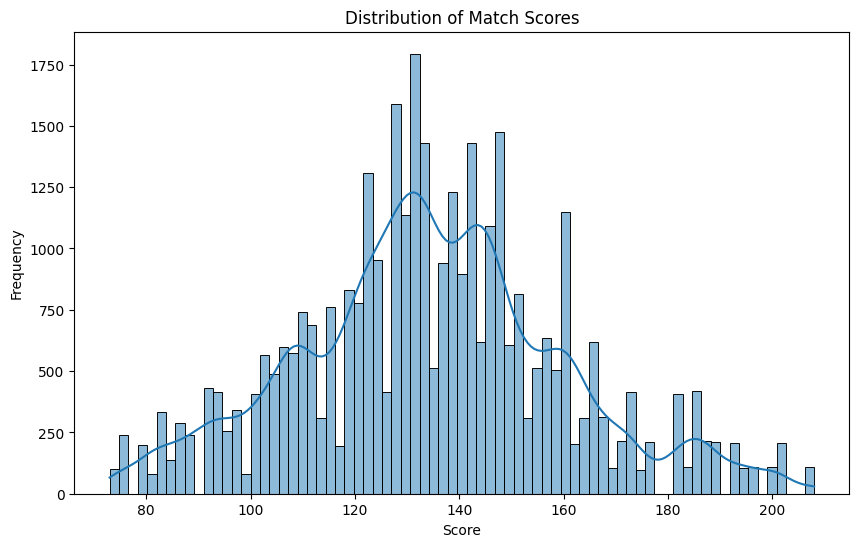

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Result'], kde=True)
plt.title('Distribution of Match Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.savefig('score_distribution.png')
plt.show()
plt.close()

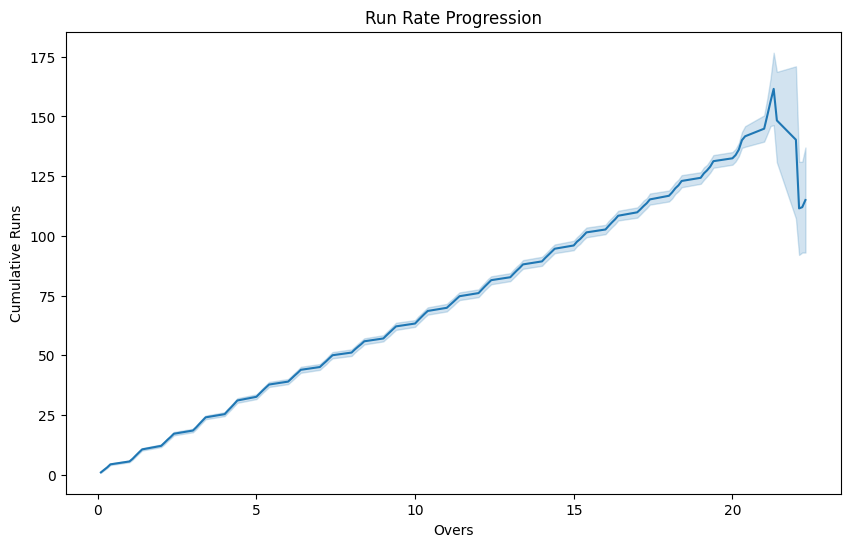

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Overs', y='Cumulative_Runs', data=df)
plt.title('Run Rate Progression')
plt.xlabel('Overs')
plt.ylabel('Cumulative Runs')
plt.savefig('run_rate_progression.png')
plt.show()
plt.close()

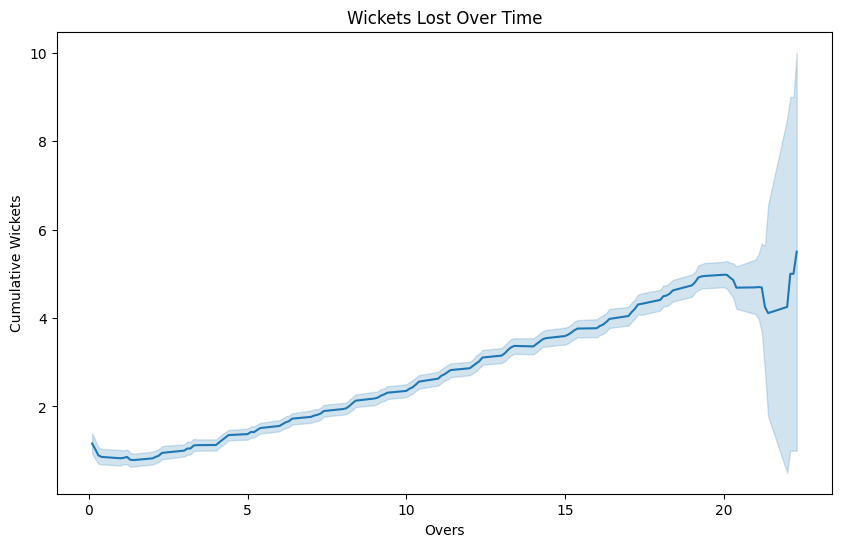

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Overs', y='Cumulative_Wickets', data=df)
plt.title('Wickets Lost Over Time')
plt.xlabel('Overs')
plt.ylabel('Cumulative Wickets')
plt.savefig('wickets_over_time.png')
plt.show()
plt.close()

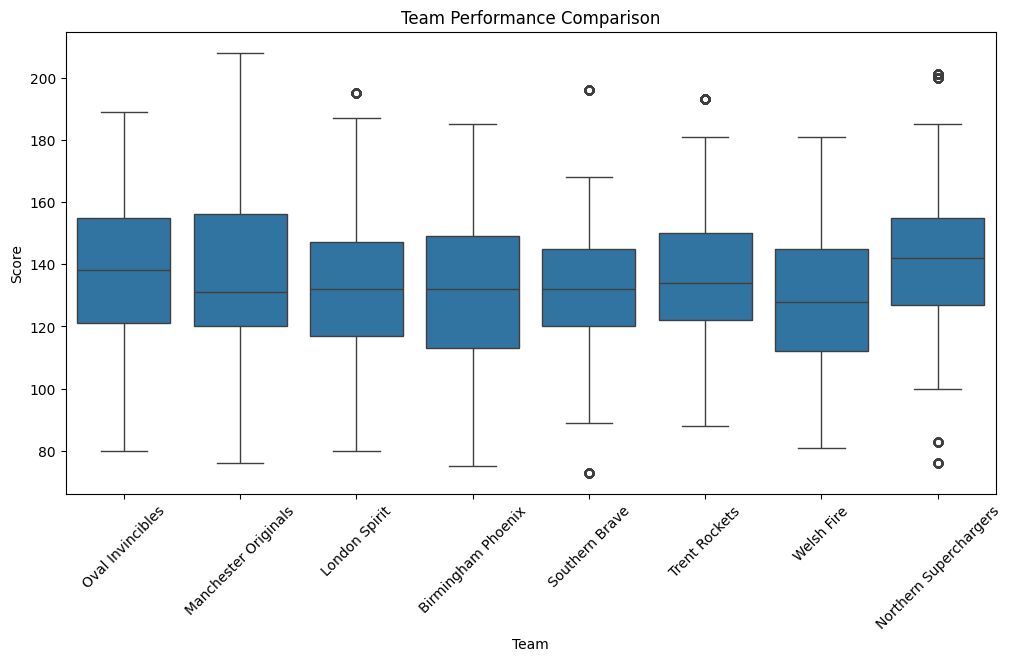

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='Result', data=df)
plt.title('Team Performance Comparison')
plt.xlabel('Team')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()
plt.close()

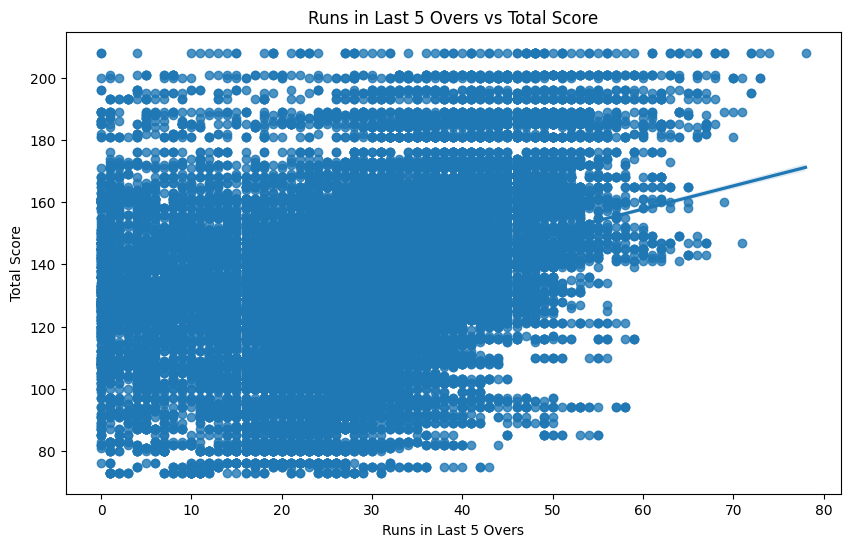

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='runs_last_5_overs', y='Result', data=df)
plt.title('Runs in Last 5 Overs vs Total Score')
plt.xlabel('Runs in Last 5 Overs')
plt.ylabel('Total Score')
plt.show()
plt.close()

<Axes: >

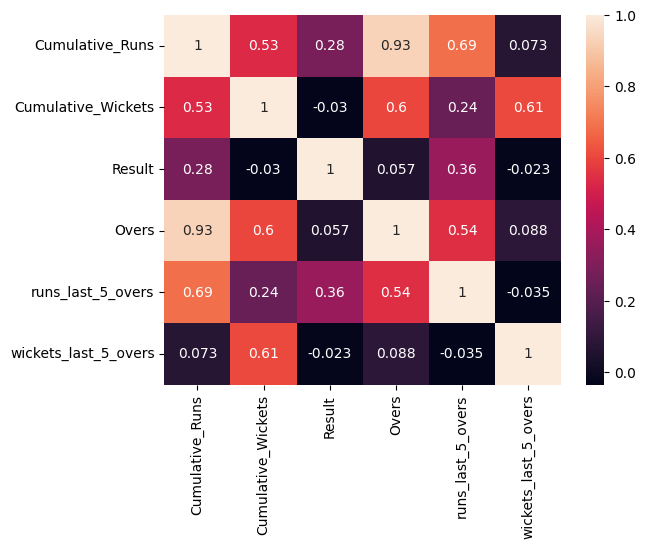

In [ ]:
numerical_df = df2.select_dtypes(include=['int64', 'float64'])
heatmap(data=numerical_df.corr(), annot=True)

Data Preprocessing and Encoding.

Performing Label Encoding.

In [ ]:
le = LabelEncoder()
for col in ['Team', 'Opposition_Team', 'Gender']:
  df2[col] = le.fit_transform(df2[col])

df2.head()

<ipython-input-30-9041e00194df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = le.fit_transform(df2[col])
<ipython-input-30-9041e00194df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = le.fit_transform(df2[col])
<ipython-input-30-9041e00194df>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,Team,Gender,Opposition_Team,Cumulative_Runs,Cumulative_Wickets,Result,Overs,runs_last_5_overs,wickets_last_5_overs
0,4,1,2,0,0,145,0.1,0,0
1,4,1,2,1,0,145,0.2,1,0
2,4,1,2,1,0,145,0.3,1,0
3,4,1,2,7,0,145,0.4,7,0
4,4,1,2,7,1,145,1.0,7,1


Performing One Hot Encoding and Column Transformation.
Applying Transformations on all the final features.

In [ ]:
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough')

In [ ]:
categorical_columns = ['Team', 'Opposition_Team', 'Gender']

numerical_columns = ['Cumulative_Runs', 'Cumulative_Wickets', 'Result', 'Overs', 'runs_last_5_overs', 'wickets_last_5_overs']

columnTransformer = ColumnTransformer([
    ('encoder', OneHotEncoder(sparse=False), categorical_columns)
], remainder='passthrough')

df2_array = columnTransformer.fit_transform(df2)

feature_names = list(columnTransformer.named_transformers_['encoder'].get_feature_names_out(categorical_columns)) + numerical_columns

df2_transformed = pd.DataFrame(df2_array, columns=feature_names)

df = pd.DataFrame(df2_transformed, columns=feature_names)

df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Team_0,Team_1,Team_2,Team_3,Team_4,Team_5,Team_6,Team_7,Opposition_Team_0,Opposition_Team_1,...,Opposition_Team_6,Opposition_Team_7,Gender_0,Gender_1,Cumulative_Runs,Cumulative_Wickets,Result,Overs,runs_last_5_overs,wickets_last_5_overs
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,145.0,0.1,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,145.0,0.2,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,145.0,0.3,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,7.0,0.0,145.0,0.4,7.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,7.0,1.0,145.0,1.0,7.0,1.0


Model Building.

Prepare Train and Test Data.

In [ ]:
features = df.drop(['Result'], axis=1)
labels = df['Result']

Spliting the Training Data into train & test.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, shuffle=True)
print(f"Training Set : {train_features.shape}\nTesting Set : {test_features.shape}")

Training Set : (28879, 23)
Testing Set : (7220, 23)


Selecting appropiate ML Algorithms.
First, I created a dictionary for multiple models to store. The, using the scikit-learn library tested out various Regression Algorithms for their fitting and accuracy scores.

In [ ]:
models = dict()

Decision Tree Regressor

In [ ]:
tree = DecisionTreeRegressor()

tree.fit(train_features, train_labels)

DecisionTreeRegressor()

In [ ]:
train_score_tree = str(tree.score(train_features, train_labels) * 100)
test_score_tree = str(tree.score(test_features, test_labels) * 100)
print(f'Train Score : {train_score_tree[:5]}%\nTest Score : {test_score_tree[:5]}%')
models["tree"] = test_score_tree

Train Score : 98.65%
Test Score : 62.89%


In [ ]:
print("---- Decision Tree Regressor - Model Evaluation ----")
print("Mean Absolute Error (MAE): {}".format(mae(test_labels, tree.predict(test_features))))
print("Mean Squared Error (MSE): {}".format(mse(test_labels, tree.predict(test_features))))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(test_labels, tree.predict(test_features)))))

---- Decision Tree Regressor - Model Evaluation ----
Mean Absolute Error (MAE): 6.789265927977839
Mean Squared Error (MSE): 246.28503000923362
Root Mean Squared Error (RMSE): 15.693470935686396


Linear Regression

In [ ]:
linreg = LinearRegression()

linreg.fit(train_features, train_labels)

LinearRegression()

In [ ]:
train_score_linreg = str(linreg.score(train_features, train_labels) * 100)
test_score_linreg = str(linreg.score(test_features, test_labels) * 100)
print(f'Train Score : {train_score_linreg[:5]}%\nTest Score : {test_score_linreg[:5]}%')
models["linreg"] = test_score_linreg

Train Score : 42.34%
Test Score : 42.82%


In [ ]:
print("---- Linear Regression - Model Evaluation ----")
print("Mean Absolute Error (MAE): {}".format(mae(test_labels, linreg.predict(test_features))))
print("Mean Squared Error (MSE): {}".format(mse(test_labels, linreg.predict(test_features))))
print("Root Mean Squared Error (RMSE): {}".format(np.sqrt(mse(test_labels, linreg.predict(test_features)))))

---- Linear Regression - Model Evaluation ----
Mean Absolute Error (MAE): 14.604372010275126
Mean Squared Error (MSE): 379.4776423213872
Root Mean Squared Error (RMSE): 19.480185890319095


Random Forest Regression

In [ ]:
forest = RandomForestRegressor()

forest.fit(train_features, train_labels)

RandomForestRegressor()

In [ ]:
train_score_forest = str(forest.score(train_features, train_labels)*100)
test_score_forest = str(forest.score(test_features, test_labels)*100)
print(f'Train Score : {train_score_forest[:5]}%\nTest Score : {test_score_forest[:5]}%')
models["forest"] = test_score_forest

Train Score : 98.04%
Test Score : 88.08%


---- Random Forest Regression - Model Evaluation ----
Mean Absolute Error (MAE): 4.99
Mean Squared Error (MSE): 76.93
Root Mean Squared Error (RMSE): 8.77
R-squared (R2) Score: 0.88

---- Feature Importance ----
             feature  importance
   runs_last_5_overs    0.169562
     Cumulative_Runs    0.148786
               Overs    0.119454
            Gender_1    0.079266
            Gender_0    0.076818
  Cumulative_Wickets    0.070411
wickets_last_5_overs    0.040720
   Opposition_Team_2    0.033090
              Team_0    0.022948
              Team_7    0.022560
   Opposition_Team_6    0.019812
   Opposition_Team_0    0.019088
              Team_2    0.018933
              Team_5    0.018767
   Opposition_Team_5    0.018666
   Opposition_Team_7    0.017547
   Opposition_Team_3    0.016843
              Team_3    0.016319
   Opposition_Team_1    0.015514
   Opposition_Team_4    0.014433
              Team_1    0.014093
              Team_4    0.013707
              Team_6    0.012

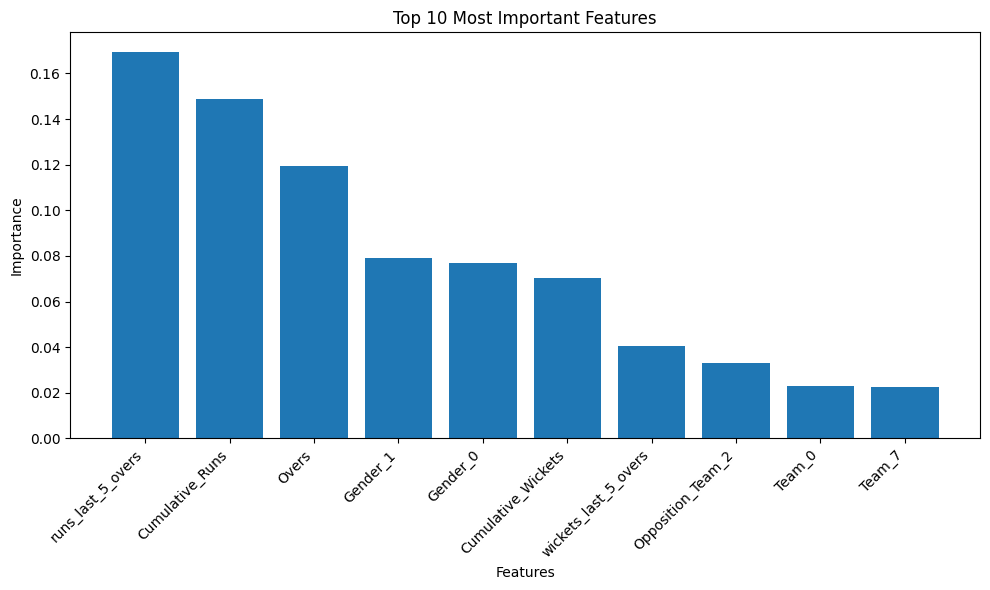

In [ ]:
print("---- Random Forest Regression - Model Evaluation ----")
predictions = forest.predict(test_features)

print("Mean Absolute Error (MAE): {:.2f}".format(mae(test_labels, predictions)))
print("Mean Squared Error (MSE): {:.2f}".format(mse(test_labels, predictions)))
print("Root Mean Squared Error (RMSE): {:.2f}".format(np.sqrt(mse(test_labels, predictions))))
print("R-squared (R2) Score: {:.2f}".format(r2_score(test_labels, predictions)))

feature_importance = forest.feature_importances_
feature_names = test_features.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("\n---- Feature Importance ----")
print(feature_importance_df.to_string(index=False))

N = 10
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['feature'][:N], feature_importance_df['importance'][:N])
plt.title(f'Top {N} Most Important Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Best Model.
Out of the above models, lets plot the accuracies of them to know the best model for prediction of accurate scores.

<BarContainer object of 3 artists>

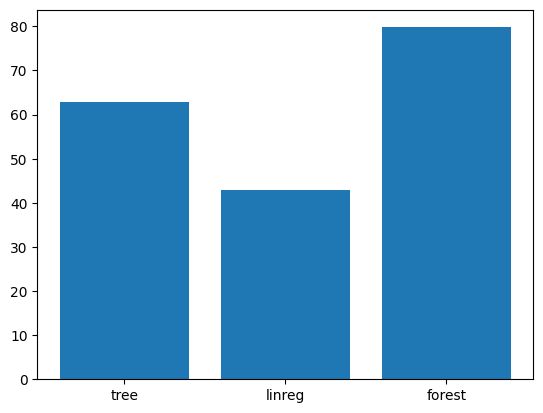

In [ ]:
model_names = list(models.keys())
accuracy = list(map(float, models.values()))

plt.bar(model_names, accuracy)

Predictions. Create a function _score_predict_, which creates a numpy prediction array out of the input features

In [ ]:
def score_predict(team, gender, opposition_team, cumulative_runs, cumulative_wickets, overs, runs_last_5_overs, wickets_last_5_overs, model):
    prediction_array = []

    if team == 'Birmingham Phoenix':
        prediction_array += [1, 0, 0, 0, 0, 0, 0, 0]
    elif team == 'London Spirit':
        prediction_array += [0, 1, 0, 0, 0, 0, 0, 0]
    elif team == 'Manchester Originals':
        prediction_array += [0, 0, 1, 0, 0, 0, 0, 0]
    elif team == 'Northern Superchargers':
        prediction_array += [0, 0, 0, 1, 0, 0, 0, 0]
    elif team == 'Oval Invincibles':
        prediction_array += [0, 0, 0, 0, 1, 0, 0, 0]
    elif team == 'Southern Brave':
        prediction_array += [0, 0, 0, 0, 0, 1, 0, 0]
    elif team == 'Trent Rockets':
        prediction_array += [0, 0, 0, 0, 0, 0, 1, 0]
    elif team == 'Welsh Fire':
        prediction_array += [0, 0, 0, 0, 0, 0, 0, 1]

    if gender == 'female':
        prediction_array += [1, 0]  # female = 1
    elif gender == 'male':
        prediction_array += [0, 1]  # male = 1

    if opposition_team == 'Birmingham Phoenix':
        prediction_array += [1, 0, 0, 0, 0, 0, 0, 0]
    elif opposition_team == 'London Spirit':
        prediction_array += [0, 1, 0, 0, 0, 0, 0, 0]
    elif opposition_team == 'Manchester Originals':
        prediction_array += [0, 0, 1, 0, 0, 0, 0, 0]
    elif opposition_team == 'Northern Superchargers':
        prediction_array += [0, 0, 0, 1, 0, 0, 0, 0]
    elif opposition_team == 'Oval Invincibles':
        prediction_array += [0, 0, 0, 0, 1, 0, 0, 0]
    elif opposition_team == 'Southern Brave':
        prediction_array += [0, 0, 0, 0, 0, 1, 0, 0]
    elif opposition_team == 'Trent Rockets':
        prediction_array += [0, 0, 0, 0, 0, 0, 1, 0]
    elif opposition_team == 'Welsh Fire':
        prediction_array += [0, 0, 0, 0, 0, 0, 0, 1]

    prediction_array += [cumulative_runs, cumulative_wickets, overs, runs_last_5_overs, wickets_last_5_overs]

    prediction_array = np.array([prediction_array])

    pred = model.predict(prediction_array)

    return int(round(pred[0]))


Testing the Model's predictions

In [ ]:
team = 'Northern Superchargers'
opposition_team = 'Manchester Originals'
gender = 'male'

score = score_predict(team, gender, opposition_team, 0, 0, 0, 0, 0, forest)
print(f'Predicted Score: {score} || Actual Score: 156')

Predicted Score: 136 || Actual Score: 150


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
